In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from pandas import DataFrame

from dataset import SyntheticBanditDatasetWithActionEmbeds
from policylearners import PolicyLearnerOverActionSpaces, PolicyLearnerOverActionEmbedSpaces
from importance_weight import marginal_pscore
from opl_plot import visualize_learning_curve, visualize_test_value

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Default settings

dim_context=5
n_actions=10
n_cat_dim=1
n_cat_per_dim=5
latent_param_mat_dim=5
is_probabilistic_embed=False
beta=0.3
val_size=500
test_size=10000
max_iter=30
num_runs=50
hidden_layer_size=(10, 10, 10)
learning_rate_init=0.1
random_state=12345

In [3]:
# Experiment 1. When the assumption of no direct effect holds, we vary epoch.
dataset = SyntheticBanditDatasetWithActionEmbeds(
    n_actions=n_actions,
    dim_context=dim_context,
    n_cat_dim=n_cat_dim,
    n_cat_per_dim=n_cat_per_dim,
    beta=beta,
    latent_param_mat_dim=latent_param_mat_dim,
    is_probabilistic_embed=False,
    random_state=random_state
)
test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
pi_b_value = (test_data["expected_reward"] * test_data["pi_b"]).sum(1).mean()
log_ = DataFrame([
    [pi_b_value] * max_iter, ["logging"] * max_iter], index=["value", "method"]
).T.reset_index()

curve_df = DataFrame()
for _ in tqdm(range(num_runs)):
    val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
    
    # Inverse Propensity Score - Policy Gradient (IPS-PG)
    ips = PolicyLearnerOverActionSpaces(
        dim_context=dim_context, 
        num_actions=n_actions, 
        max_iter=max_iter,
        hidden_layer_size=hidden_layer_size,
        learning_rate_init=learning_rate_init,
    )
    ips.fit(val_data, test_data)
    ips_ = DataFrame([ips.test_value, ["IPS-PG"] * max_iter], index=["value", "method"]).T.reset_index()
    
    # Marginalized Inverse Propensity Score - Policy Gradient (MIPS-PG)
    # We have a "deterministic" embedding.
    val_data["pscore_e"] = marginal_pscore(data=val_data)
    mips = PolicyLearnerOverActionEmbedSpaces(
        hidden_layer_size=hidden_layer_size,
        dim_context=dim_context, 
        num_actions=n_actions,
        dim_action_context=n_cat_dim,
        num_category=n_cat_per_dim,
        max_iter=max_iter,
        learning_rate_init=learning_rate_init,
    )
    mips.fit(val_data, test_data)
    mips_ = DataFrame([mips.test_value, ["MIPS-PG"] * max_iter], index=["value", "method"]).T.reset_index()
    
    curve_df = pd.concat([curve_df, pd.concat([log_, ips_, mips_])])
curve_df.reset_index(inplace=True)   

100% 50/50 [01:37<00:00,  1.95s/it]


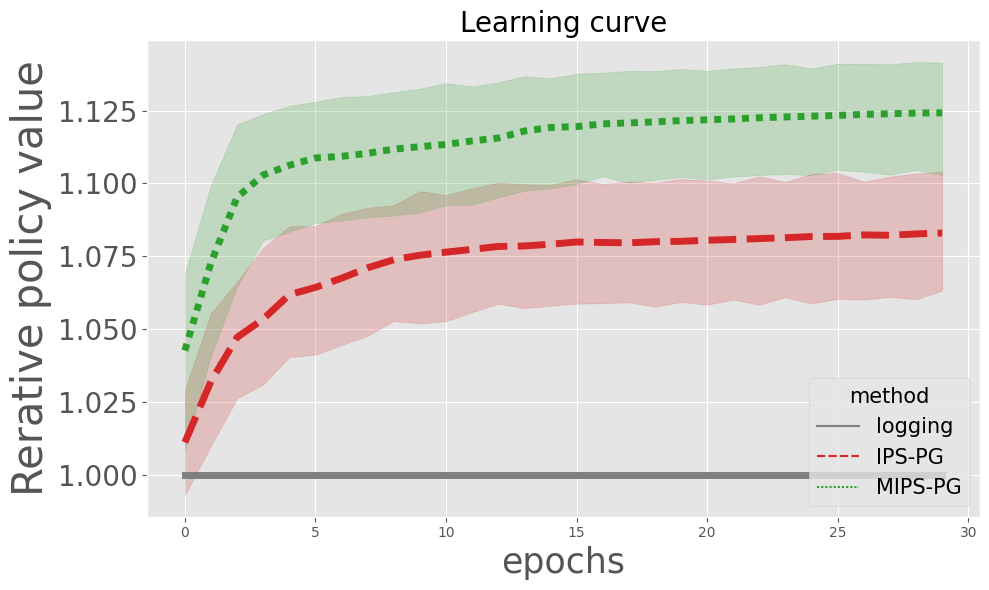

In [4]:
visualize_learning_curve(curve_df, pi_b_value)

In [5]:
# Experiment 2. When the assumption of no direct effect holds, we vary the number of actions.

result_df_list=[]
unique_actions_list=[10, 50, 250, 1250]
for n_actions in unique_actions_list:
    
    dataset = SyntheticBanditDatasetWithActionEmbeds(
        n_actions=n_actions,
        dim_context=dim_context,
        n_cat_dim=n_cat_dim,
        n_cat_per_dim=n_cat_per_dim,
        beta=beta,
        latent_param_mat_dim=latent_param_mat_dim,
        is_probabilistic_embed=False,
        random_state=random_state
    )
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
    pi_b_value = (test_data["expected_reward"] * test_data["pi_b"]).sum(1).mean()
    
    test_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_actions={n_actions}"):
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        true_value_of_learned_policies = dict()
        true_value_of_learned_policies["logging"] = pi_b_value
        
        # Inverse Propensity Score - Policy Gradient (IPS-PG)
        ips = PolicyLearnerOverActionSpaces(
            dim_context=dim_context, 
            num_actions=n_actions, 
            max_iter=max_iter,
            hidden_layer_size=hidden_layer_size,
            learning_rate_init=learning_rate_init,
        )
        ips.fit(val_data, test_data)
        pi_ips = ips.predict(test_data)
        true_value_of_learned_policies["IPS-PG"] = (test_data["expected_reward"] * pi_ips).sum(1).mean()
        
        # Marginalized Inverse Propensity Score - Policy Gradient (MIPS-PG)
        # We have a "deterministic" embedding.
        val_data["pscore_e"] = marginal_pscore(data=val_data)
        mips = PolicyLearnerOverActionEmbedSpaces(
            hidden_layer_size=hidden_layer_size,
            dim_context=dim_context, 
            num_actions=n_actions,
            dim_action_context=n_cat_dim,
            num_category=n_cat_per_dim,
            max_iter=max_iter,
            learning_rate_init=learning_rate_init,
        )
        mips.fit(val_data, test_data)
        pi_mips = mips.predict(test_data)
        true_value_of_learned_policies["MIPS-PG"] = (test_data["expected_reward"] * pi_mips).sum(1).mean()
        
        test_policy_value_list.append(true_value_of_learned_policies)
    
    result_df = DataFrame(test_policy_value_list).stack().reset_index(1)\
        .rename(columns={"level_1": "method", 0: "value"})
    result_df["x"] = n_actions
    result_df["pi_b_value"] = pi_b_value
    result_df["rel_value"] = result_df["value"] / pi_b_value
    result_df_list.append(result_df)

result_df = pd.concat(result_df_list).reset_index(level=0)

num_actions=10: 100% 50/50 [01:35<00:00,  1.91s/it]
num_actions=50: 100% 50/50 [01:42<00:00,  2.05s/it]
num_actions=250: 100% 50/50 [04:15<00:00,  5.11s/it]
num_actions=1250: 100% 50/50 [10:20<00:00, 12.42s/it]


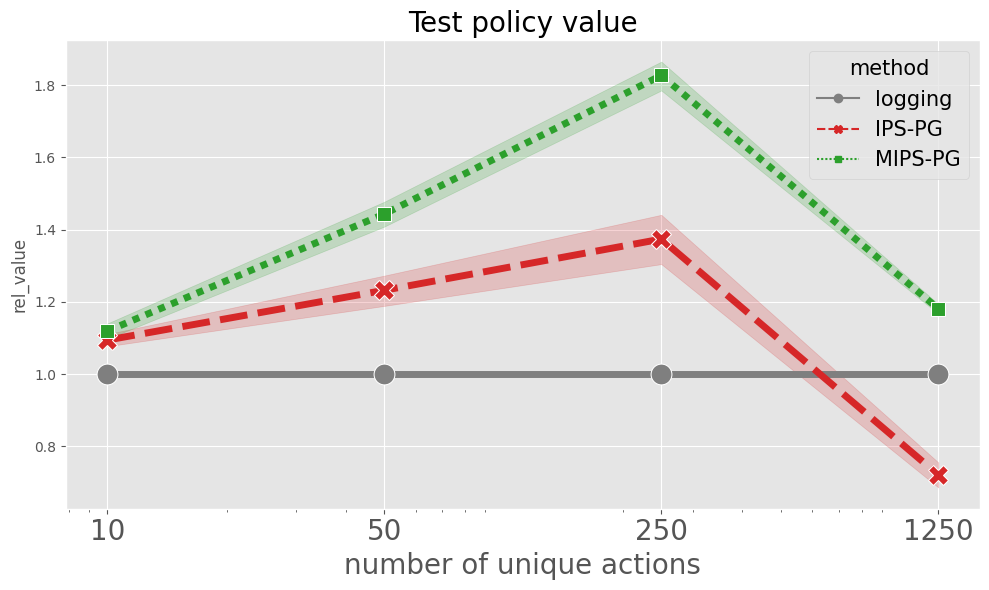

In [6]:
visualize_test_value(
    result_df=result_df,
    x_label="number of unique actions",
    x_scale="log"
)